In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

In [4]:
#ee.Authenticate()
#geemap.update_package()

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

##Adding every plot coordinate
allplots_ga = 'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/GA_allplots_NEW.csv'
allplots_va= pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Coordinates and biomass/va_allpoints.csv')
allplots_va = allplots_va[allplots_va['liveMass'].notna()]
allplots_va = allplots_va[allplots_va['Latitude'].notna()]
allplots_va = allplots_va.drop(columns = ['deadMass', 'collectDate', 'totalMass', 'Ell', 'MSL', 'latitude', 'longitude'])
df_temp=allplots_va.copy()
df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size]
    }
)
df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N'
]
allplots_va = df_temp
s_patens = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Massachusetts/LTE-MP-LPP-biomass.csv')
s_alterniflora = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Massachusetts/LTE-MP-LPA-biomass.csv')
s_patens['Latitude'] = 42.730953216553
s_patens['Longitude'] = -70.842918395996
s_alterniflora['Latitude'] = 42.731742858887
s_alterniflora['Longitude'] = -70.842468261719
s_patens.rename(columns={'LIVE biomass':'liveMass'}, inplace=True)
s_alterniflora.rename(columns={'MEAN BIOMASS':'liveMass'}, inplace=True)
df = pd.concat([s_patens, s_alterniflora])
df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
dfx =  df.groupby(['SITE', 'Date'], as_index = False).aggregate(
    {
        'Longitude':[np.mean], 'Latitude':[np.mean], 'liveMass':[np.mean, np.size], 
        'MONTH':'first', 'YEAR':'first'
    }
) 
dfx.columns = [
    'Site','Date','Longitude','Latitude','liveMass', 'Sample size','Month', 'Year'
]

dfx.loc[dfx['Site'] == 'LTE-MP-LPP', 'Latitude'] = 42.730953216553
dfx.loc[dfx['Site'] == 'LTE-MP-LPP', 'Longitude'] = -70.842918395996
dfx.loc[dfx['Site'] == 'LTE-MP-LPA', 'Latitude'] = 42.731742858887
dfx.loc[dfx['Site'] == 'LTE-MP-LPA', 'Longitude'] = -70.842468261719

fc_ma = geemap.pandas_to_ee(dfx, latitude = 'Latitude', longitude = 'Longitude')
fc_va = geemap.pandas_to_ee(allplots_va, latitude = "Latitude", longitude = "Longitude")
fc_ga = geemap.csv_to_ee(allplots_ga, latitude = "Latitude", longitude = "Longitude")

Map.addLayer(fc_ma, {}, "MA")
Map.addLayer(fc_va, {}, "VA")
Map.addLayer(fc_ga, {}, "GA")

# Map

In [5]:
yr_start = 2021
yr_end = 2021

ls_ma = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_ma) \
    .filter(ee.Filter.calendarRange(yr_start, yr_end,'year'))

ls_va = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_va) \
    .filter(ee.Filter.calendarRange(yr_start, yr_end,'year'))

ls_ga = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_ga) \
    .filter(ee.Filter.calendarRange(yr_start, yr_end,'year'))

In [6]:
# Apply scaling factors, cloud mask, and FLATS
def addFLATS(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(flats.rename('flats'))

def maskFLATS(image):
    mask1 = image.select('flats').lte(0.1) #less than or equal to 0.1 - change?
    return image.updateMask(mask1)

def addpheno(image):
    pheno = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addndvi(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addevi(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(evi.rename('evi'))

def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

scaled_ma = ls_ma.map(maskL8sr).map(addFLATS).map(maskFLATS).map(addpheno).map(addndvi).map(addevi).map(addnirv)
scaled_va = ls_va.map(maskL8sr).map(addFLATS).map(maskFLATS).map(addpheno).map(addndvi).map(addevi).map(addnirv)
scaled_ga = ls_ga.map(maskL8sr).map(addFLATS).map(maskFLATS).map(addpheno).map(addndvi).map(addevi).map(addnirv)

In [7]:
#https://developers.google.com/earth-engine/apidocs/ee-imagecollection-getregion

#alternatively, ee.image sample? https://developers.google.com/earth-engine/api_docs#ee.image.sample

In [8]:
#LTER domains:
gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simple.shp' ##Simplified GCE domain - reduced number of vertices
vcr_clip = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simple.shp' ##Simplified VCR domain - reduced number of vertices
pie_clip = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simple.shp' ##Simplified PIE domain - reduced number of vertices
wet_ga = geemap.shp_to_ee(gce_clip)
wet_va = geemap.shp_to_ee(vcr_clip)
wet_ma = geemap.shp_to_ee(pie_clip)
joinedFeatures = wet_ga.union()

# clip_ga = scaled_ga.map(lambda image: image.clip(wet_ga))
# clip_0 = ee.Image(clip_ga.toList(clip_ga.size()).get(1)) ##Second image in collection

# Map.addLayer(clip_0, l8_param, 'Landsat 2020')
Map.addLayer(ee.Image(scaled_ga.toList(scaled_ga.size()).get(0)), l8_param, '2020 Landsat 8 collection')
Map.addLayer(joinedFeatures, {}, 'GCE domain')
Map

NameError: name 'l8_param' is not defined

In [ ]:
#Time series of pheno band

#Add NIRV index! NIR*ndvi

out_dir = os.path.expanduser('~/Downloads')

out_ga = os.path.join(out_dir, 'nirv_ga21.csv')
out_va = os.path.join(out_dir, 'nirv_va21.csv')
out_ma = os.path.join(out_dir, 'nirv_ma21.csv')

collection_ga = scaled_ga \
                  .select("nirv")

collection_va = scaled_va \
                  .select("nirv")

collection_ma = scaled_ma \
                  .select("nirv")

# geemap.zonal_statistics(in_value_raster = collection_ga, in_zone_vector = wet_ga, \
#                 out_file_path = out_ga, statistics_type='MEAN', \
#                 scale = 30)

# geemap.zonal_statistics(in_value_raster = collection_va, in_zone_vector = wet_va, \
#                 out_file_path = out_va, statistics_type='MEAN', \
#                 scale = 30)

# geemap.zonal_statistics(in_value_raster = collection_ma, in_zone_vector = wet_ma, \
#                 out_file_path = out_ma, statistics_type='MEAN', \
#                 scale = 30)

In [9]:
#Read files, create time series
import glob
pathga = r'C:/Users/arj26323/Documents/Data/Phenology/NIRv/GA'
pathva = r'C:/Users/arj26323/Documents/Data/Phenology/NIRv/VA' 
pathma = r'C:/Users/arj26323/Documents/Data/Phenology/NIRv/MA'

all_files = glob.glob(pathga + "/*.csv")

li = []

for filename in all_files:
    df_ga = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_ga)

df_ga = pd.concat(li, axis=1, ignore_index=False)

df_ga

all_files = glob.glob(pathva + "/*.csv")

li = []

for filename in all_files:
    df_va = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_va)

df_va = pd.concat(li, axis=1, ignore_index=False)

df_va

all_files = glob.glob(pathma + "/*.csv")

li = []

for filename in all_files:
    df_ma = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_ma)

df_ma = pd.concat(li, axis=1, ignore_index=False)

df_ma

,LC08_012030_20130404_nirv,LC08_012030_20130409_nirv,LC08_012030_20130416_nirv,LC08_012030_20130502_nirv,LC08_012030_20130518_nirv,LC08_012030_20130603_nirv,LC08_012030_20130619_nirv,LC08_012030_20130705_nirv,LC08_012030_20130721_nirv,LC08_012030_20130806_nirv,...,ATTRIBUTE,MinSimpTol,Shape_Area,InPoly_FID,Shape_Le_1,WETLAND_TY,SHAPE_Leng,SimPgnFlag,MaxSimpTol,ACRES
0,0.017847,0.022044,NaN,NaN,0.032349,NaN,0.147272,0.173102,NaN,0.175243,...,E2EM1/USN,1,9177.019941,1,461.455940,Estuarine and Marine Wetland,461.455940,0,1,2.267691
1,0.013984,0.017254,0.012535,NaN,0.024813,NaN,0.119507,0.136021,NaN,0.117476,...,E2EM1/USN,1,21203.180011,2,620.509117,Estuarine and Marine Wetland,620.509117,0,1,5.239420
2,0.017191,0.018582,0.021898,NaN,0.023357,NaN,0.120618,0.118130,NaN,0.126564,...,E2EM1/USN,1,15209.566255,3,702.691573,Estuarine and Marine Wetland,702.691573,0,1,3.758366
3,0.021767,0.025433,0.016762,NaN,0.029448,NaN,0.076999,0.088700,NaN,0.087555,...,E2EM1/USN,1,25483.539915,4,670.789783,Estuarine and Marine Wetland,670.789783,0,1,6.297120
4,0.052515,NaN,0.053087,0.043222,0.053817,NaN,0.094198,0.102435,NaN,0.090933,...,E2EM1N,1,36757.454014,5,909.258281,Estuarine and Marine Wetland,909.258281,0,1,9.082965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,0.018704,NaN,0.023298,0.013457,0.025982,NaN,0.034886,NaN,NaN,0.110224,...,E2US3N,1,37061.557458,592,2928.852309,Estuarine and Marine Wetland,2928.852309,0,1,9.158110
592,0.022451,0.024185,0.022342,0.019723,0.022588,NaN,0.045573,0.072672,NaN,0.084869,...,E2USN,1,634399.658781,593,18770.801901,Estuarine and Marine Wetland,18770.820927,0,1,156.763532
593,0.029861,0.022850,0.029374,0.025965,0.025699,NaN,0.054077,0.089561,NaN,0.114532,...,E2USN,1,127789.705967,594,5402.061457,Estuarine and Marine Wetland,5402.069788,0,1,31.577508
594,0.032749,0.034082,0.031175,0.031707,0.034801,NaN,0.062473,0.074894,NaN,0.073067,...,E2USN,1,184109.952640,595,6287.514332,Estuarine and Marine Wetland,6287.514332,0,1,45.494560


In [10]:
#Feesh
for col in df_ga.columns:
    print(col)

LC08_016038_20130328_nirv
LC08_016038_20130412_nirv
LC08_016038_20130428_nirv
LC08_016038_20130514_nirv
LC08_016038_20130530_nirv
LC08_016038_20130615_nirv
LC08_016038_20130701_nirv
LC08_016038_20130717_nirv
LC08_016038_20130802_nirv
LC08_016038_20130818_nirv
LC08_016038_20130903_nirv
LC08_016038_20130919_nirv
LC08_016038_20131005_nirv
LC08_016038_20131021_nirv
LC08_016038_20131106_nirv
LC08_016038_20131122_nirv
LC08_016038_20131224_nirv
LC08_016039_20130701_nirv
LC08_016039_20130717_nirv
LC08_016039_20130802_nirv
LC08_016039_20130818_nirv
LC08_016039_20130903_nirv
LC08_016039_20130919_nirv
LC08_016039_20131005_nirv
LC08_016039_20131021_nirv
LC08_016039_20131106_nirv
LC08_016039_20131122_nirv
LC08_016039_20131208_nirv
LC08_016039_20131224_nirv
LC08_017038_20130622_nirv
LC08_017038_20130708_nirv
LC08_017038_20130724_nirv
LC08_017038_20130809_nirv
LC08_017038_20130825_nirv
LC08_017038_20130910_nirv
LC08_017038_20131012_nirv
LC08_017038_20131028_nirv
LC08_017038_20131113_nirv
LC08_017038_

In [11]:
import datetime
dates_ga = df_ga.filter(regex='016038') ##Based on Landsat 8 image collection prefix! With GA, only getting one scene
dates_ga.columns = pd.to_datetime(dates_ga.columns.str.split('_').str[2])
dates_ga

dates_va = df_va.filter(regex='LC') ##Based on Landsat 8 image collection prefix!
dates_va.columns = pd.to_datetime(dates_va.columns.str.split('_').str[2])
dates_va

dates_ma = df_ma.filter(regex='LC') ##Based on Landsat 8 image collection prefix!
dates_ma.columns = pd.to_datetime(dates_ma.columns.str.split('_').str[2])
dates_ma

,2013-04-04,2013-04-09,2013-04-16,2013-05-02,2013-05-18,2013-06-03,2013-06-19,2013-07-05,2013-07-21,2013-08-06,...,2021-07-11,2021-07-27,2021-08-12,2021-08-28,2021-09-13,2021-09-29,2021-10-15,2021-10-31,2021-11-16,2021-12-18
0,0.017847,0.022044,NaN,NaN,0.032349,NaN,0.147272,0.173102,NaN,0.175243,...,NaN,0.144039,0.124674,NaN,0.094367,NaN,NaN,NaN,NaN,NaN
1,0.013984,0.017254,0.012535,NaN,0.024813,NaN,0.119507,0.136021,NaN,0.117476,...,NaN,0.165266,0.122268,NaN,0.094593,NaN,NaN,NaN,0.069780,NaN
2,0.017191,0.018582,0.021898,NaN,0.023357,NaN,0.120618,0.118130,NaN,0.126564,...,NaN,0.192023,0.112912,NaN,0.086126,NaN,NaN,NaN,NaN,NaN
3,0.021767,0.025433,0.016762,NaN,0.029448,NaN,0.076999,0.088700,NaN,0.087555,...,NaN,0.093698,0.089447,NaN,0.071816,NaN,NaN,NaN,0.032019,NaN
4,0.052515,NaN,0.053087,0.043222,0.053817,NaN,0.094198,0.102435,NaN,0.090933,...,NaN,0.093329,0.099734,NaN,0.066081,NaN,NaN,NaN,0.017846,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,0.018704,NaN,0.023298,0.013457,0.025982,NaN,0.034886,NaN,NaN,0.110224,...,NaN,0.058121,0.054036,NaN,0.042245,0.041139,NaN,NaN,0.009577,NaN
592,0.022451,0.024185,0.022342,0.019723,0.022588,NaN,0.045573,0.072672,NaN,0.084869,...,0.078622,0.047512,0.063820,NaN,0.036018,NaN,NaN,NaN,0.022695,NaN
593,0.029861,0.022850,0.029374,0.025965,0.025699,NaN,0.054077,0.089561,NaN,0.114532,...,0.092038,0.069734,0.077102,NaN,0.045786,NaN,NaN,NaN,0.016496,NaN
594,0.032749,0.034082,0.031175,0.031707,0.034801,NaN,0.062473,0.074894,NaN,0.073067,...,0.074678,0.077612,0.087793,NaN,0.049067,NaN,NaN,NaN,0.035072,NaN


In [12]:
mean_ma = dates_ma.mean().dropna()
mean_va = dates_va.mean().dropna()
mean_ga = dates_ga.mean().dropna()

ga = pd.DataFrame(mean_ga, index = None, columns = ['NIRv_av'])
ga['Date'] = ga.index
ga['LTER'] = 'GCE'

va = pd.DataFrame(mean_ma, index = None, columns = ['NIRv_av'])
va['Date'] = va.index
va['LTER'] = 'VCR'

ma = pd.DataFrame(mean_va, index = None, columns = ['NIRv_av'])
ma['Date'] = ma.index
ma['LTER'] = 'PIE'

ga

df2 = pd.concat([ma, va, ga], axis = 1)
df2


,NIRv_av,Date,LTER,NIRv_av,Date,LTER,NIRv_av,Date,LTER
2013-03-20,0.019923,2013-03-20,PIE,NaN,NaT,NaN,NaN,NaT,NaN
2013-03-28,NaN,NaT,NaN,NaN,NaT,NaN,0.05341,2013-03-28,GCE
2013-03-30,NaN,NaT,NaN,0.040173,2013-03-30,VCR,NaN,NaT,NaN
2013-04-04,NaN,NaT,NaN,0.034204,2013-04-04,VCR,NaN,NaT,NaN
2013-04-07,0.022326,2013-04-07,PIE,NaN,NaT,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...
2021-11-16,NaN,NaT,NaN,0.046791,2021-11-16,VCR,NaN,NaT,NaN
2021-11-30,0.020272,2021-11-30,PIE,NaN,NaT,NaN,NaN,NaT,NaN
2021-12-14,NaN,NaT,NaN,NaN,NaT,NaN,0.05902,2021-12-14,GCE
2021-12-16,0.031642,2021-12-16,PIE,NaN,NaT,NaN,NaN,NaT,NaN


<AxesSubplot:xlabel='Date', ylabel='NIRv_av'>

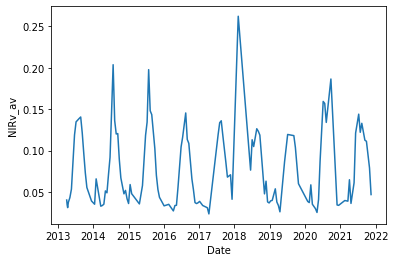

In [13]:
import seaborn as sns

sns.lineplot(x = "Date", y = "NIRv_av", data = va)

# g = sns.FacetGrid(data=df2, hue='LTER', aspect=1.5, palette='BuGn')
# g.map(sns.lineplot, 'Date', 'NIRv_av').add_legend()


,mean,sem,NIRv_av,Month,LTER
Date,,,,,
1,0.056793,0.001965,0.056793,Jan,GCE
2,0.051035,0.001999,0.051035,Feb,GCE
3,0.056259,0.002085,0.056259,Mar,GCE
4,0.068854,0.001903,0.068854,Apr,GCE
5,0.078966,0.001441,0.078966,May,GCE
6,0.087785,0.002752,0.087785,Jun,GCE
7,0.087311,0.002662,0.087311,Jul,GCE
8,0.086401,0.003566,0.086401,Aug,GCE
9,0.088086,0.004264,0.088086,Sep,GCE


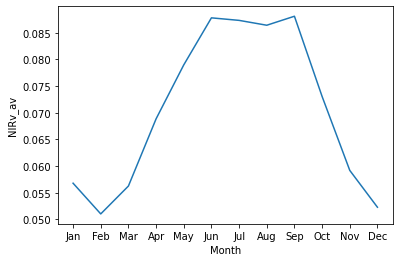

In [14]:
import calendar
gax = ga.groupby([ga.Date.dt.month])['NIRv_av'].agg(['mean', 'sem'])
gax['NIRv_av'] = gax['mean']
gax['Month'] = gax.index
gax['Month'] = gax['Month'].apply(lambda x: calendar.month_abbr[x])
gax['LTER'] = 'GCE'

sns.lineplot(x = "Month", y = "NIRv_av", data = gax)
gax

<AxesSubplot:xlabel='Month', ylabel='NIRv_av'>

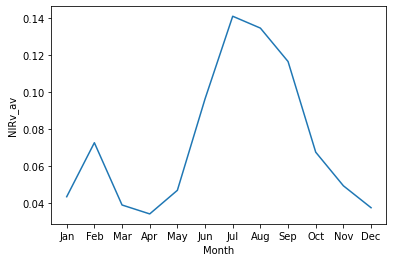

In [15]:
vax = va.groupby([va.Date.dt.month])['NIRv_av'].agg(['mean', 'sem'])
vax['NIRv_av'] = vax['mean']
vax['Month'] = vax.index
vax['Month'] = vax['Month'].apply(lambda x: calendar.month_abbr[x])
vax['LTER'] = 'VCR'

sns.lineplot(x = "Month", y = "NIRv_av", data = vax)

<AxesSubplot:xlabel='Month', ylabel='NIRv_av'>

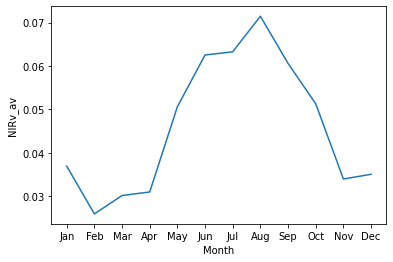

In [16]:
ma2 = ma.groupby([ma.Date.dt.month])['NIRv_av'].agg(['mean', 'sem'])
ma2['NIRv_av'] = ma2['mean']
ma2['Month'] = ma2.index
ma2['Month'] = ma2['Month'].apply(lambda x: calendar.month_abbr[x])
ma2['LTER'] = 'PIE'


sns.lineplot(x = "Month", y = "NIRv_av", data = ma2)

ValueError: Could not interpret value `NIRv_av` for parameter `x`

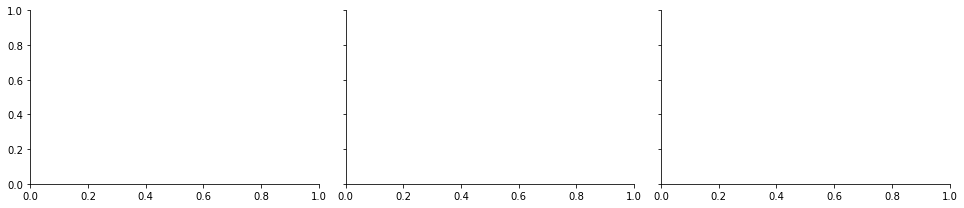

In [167]:
df3 = pd.concat([gax, vax, ma2])
df3

g = sns.FacetGrid(data=df3, col='LTER', aspect=1.5)
g.map(sns.lineplot(x ='Month', y = 'NIRv_av'))


In [162]:
df3

,mean,sem,NIRv_av,Month,LTER
Date,,,,,
1,0.056793,0.001965,0.056793,Jan,GCE
2,0.051035,0.001999,0.051035,Feb,GCE
3,0.056259,0.002085,0.056259,Mar,GCE
4,0.068854,0.001903,0.068854,Apr,GCE
5,0.078966,0.001441,0.078966,May,GCE
6,0.087785,0.002752,0.087785,Jun,GCE
7,0.087311,0.002662,0.087311,Jul,GCE
8,0.086401,0.003566,0.086401,Aug,GCE
9,0.088086,0.004264,0.088086,Sep,GCE
